# Machine Learning LAB 3: CLUSTERING - K-means and linkage-based clustering

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks about **CLUSTERING**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB02.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Laura Ravagnani

**ID Number**: 2104271

---

## Import all the necessary Python libraries

In [110]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [111]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [112]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [113]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [114]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [115]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) K-means clustering

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [116]:
# Fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2104271  # insert your ID number here
np.random.seed(ID)


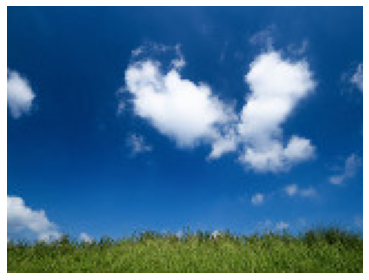

landscape image shape is: (120, 160, 3)


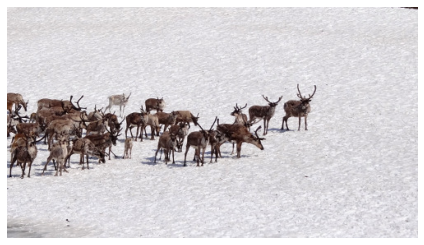

reindeer image shape is: (281, 500, 3)


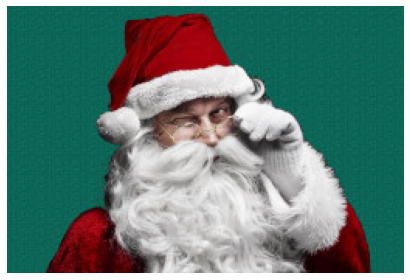

santa image shape is: (172, 256, 3)


In [117]:
# Load the provided images and display them (if you like you can experiment with other images)
# To load the images use the function plt.imread(<path_to_iamge>)

im_landscape = plt.imread('data/landscape.jpg')
im_reindeer = plt.imread('data/reindeer.jpg')
im_santa = plt.imread('data/santaclaus2.jpg')

# Plot the images with their shapes
# Sugestion: use the function img_plot()
img_plot(im_landscape)
print('landscape image shape is:', im_landscape.shape)

img_plot(im_reindeer)
print('reindeer image shape is:', im_reindeer.shape)

img_plot(im_santa)
print('santa image shape is:', im_santa.shape)


We are going to start by using the Santa Claus image.


In [118]:
# Reshape the data to a matrix of num_pixels x 3 
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)

num_pixel = im_santa.shape[0] * im_santa.shape[1]   # total mumber of pixels
im_santa_r = im_santa.reshape(num_pixel, 3)         # reshaped santa image
im_santa_norm = im_santa_r/255.                     # normalized santa image

# Print the shape of the data and the min and max values of the pixels
print('the reshaped santa array has shape:', im_santa_norm.shape, '\nthe minimum value of the pixels is', im_santa_norm.min(), 'and the maximum is:', im_santa_norm.max())

the reshaped santa array has shape: (44032, 3) 
the minimum value of the pixels is 0.0 and the maximum is: 1.0


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

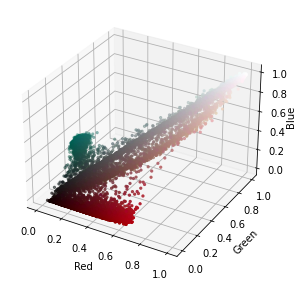

In [119]:
# Sugestion: use the function scatter_plot()
# ADD YOUR CODE HERE
scatter_plot(im_santa_norm)

### TO DO (A.1)
Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [120]:
import math as m

In [121]:
def my_kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # Generate random centers
    # use sigma and mean to ensure it represent the whole data
    
    centroids = points[np.random.choice(points.shape[0], k, replace=False)]    # initial centroid is a random point
    prev_error = 100000
    error = [9999]

    # Iterate until the estimate of that center stays the same or max iteration are reached
    iters = 0
    while (error[iters] != prev_error) and iters < max_iters:
        # Measure the distance to every center
        dist = np.array([[m.dist(centroids[i], points[j]) for i in range(k)] for j in range(points.shape[0])])    # matrix with distance from every center

        # Assign all training data to closest center
        clusters = np.array([dist[i].argmin() for i in range(dist.shape[0])])       # array with the label of the cluster assigned to every point

        # Calculate mean for every cluster and update the center
        centroids = np.array([np.mean(points[clusters == i], axis = 0) for i in range(k)])
        
        # Update the error
        dist = np.array([[m.dist(centroids[i], points[j]) for i in range(k)] for j in range(points.shape[0])])      # updated distance matrix
        min_dist = np.array([dist[i,j] for i,j in enumerate(clusters)])     # array with the distance of every point to its closest cluster
        
        error.append(sum(min_dist**2))      # assign error of the corrisponding iteration
        prev_error = error[iters]           # update previous error

        # Update the iteration counter
        iters += 1

    return centroids, clusters, error

### TO DO (A.2)

Now try the function you developed on the Santaclaus image with three clusters (k=3). 

Then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids).

The errors at every iteration are: [9999, 2233.1921742374316, 1154.4359494148523, 1100.5511997727815, 1094.1205443396984, 1093.0740813823468, 1092.90562174887, 1092.8827166076496, 1092.8772697296574, 1092.8767238334776, 1092.8765497481986, 1092.8765497481986]


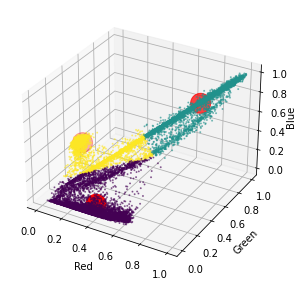

In [122]:
# Run your K-means function on the data
k = 3
centroids, clusters, error = my_kmeans(im_santa_norm, k)

# Print the errors:
print('The errors at every iteration are:', error)

# Plot the results
scatter_plot(im_santa_norm, clusters, centroids)

### TO DO (A.3) 
Plot the value of the error versus the number of iterations

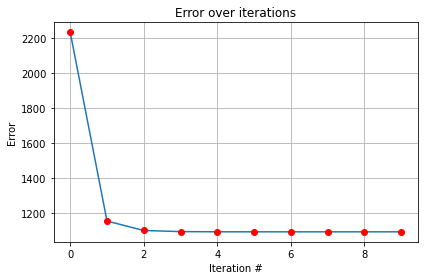

In [123]:
# Sugestion: use the function error_plot()
error_plot(error)

### TO DO (A.4)
Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [124]:
# Define the K-means model
model = KMeans(n_clusters = 3, n_init = 'auto', init = 'random', max_iter = 50)

# Fit the model to the data
model.fit(im_santa_norm)
sk_clusters = model.labels_     # array with the label of the cluster assigned to every point

# Get the cluster centers
sk_centroids = model.cluster_centers_   # coordinates of the centers

Perform the same plot as above but with the output of the k-means function provided in sklearn.

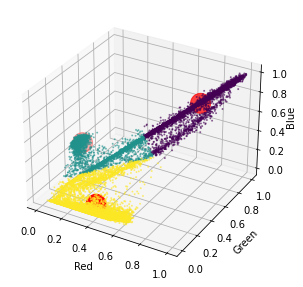

In [125]:
scatter_plot(im_santa_norm, sk_clusters, sk_centroids)

### TO DO (A.Q1) [Answare the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

**ANSWER A.Q2:** The two plots match both for the clusters and the centroid positions. 

### TO DO (A.5)

Now display the segmented image based on the two clusters found above with the k-means functions by sklearn.

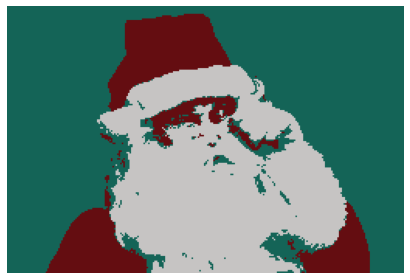

In [126]:
# Extarct the color values of the centers
sk_new_santa = np.array([sk_centroids[i] for i in sk_clusters])     # assign to every point the coordinates of its cluster center

# Reshape the data to the original image shape
sk_santa_re = sk_new_santa.reshape((172, 256, 3))   

# Plot the recolored image
img_plot(sk_santa_re)

Now display the segmented image based on the two clusters found above with the k-means functions implemented by yourselves.

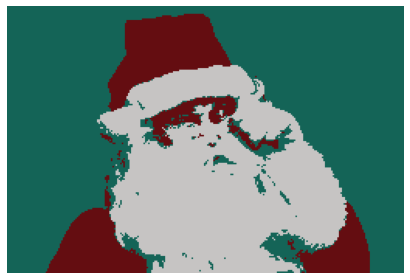

In [127]:
# Extarct the color values of the centers
new_santa = np.array([centroids[i] for i in clusters])

# Reshape the data to the original image shape
santa_re = new_santa.reshape((172, 256, 3))   

# Plot the recolored image
img_plot(santa_re)

### TO DO (A.Q2) [Answare the following]

What do you observe? Do you think clustering is useful for image segmenation? And for image compression? Comment your answer.

**ANSWER A.Q1:** We can observe that the original image can still be recognize.\
Clustering can be useful for image segmentation, but if the original image contains small details (like the glasses in santa image) they are difficult to detect. The more clusters we use, the more details can be observed.\
Clustering can also be useful for image compression if there are storage issues. The problem for small details still remains. The goal should be to find a reasonable number of cluster such that the details still appear even if the image is compressed.

### TO DO (A.6)

Now load the landscape image (optional: try also with the reindeer image) and segment it using kmeans with k varying from 2 to 15 clusters. You can use the sklearn implementation.

Then plot the resulting data points in the 3-dimensional space, each point must be colored based on the cluster membership.

the reshaped landscape array has shape: (19200, 3) 
the minimum value of the pixels is 0.0 and the maximum is: 1.0

K-means clustering with different values of K (2-15):


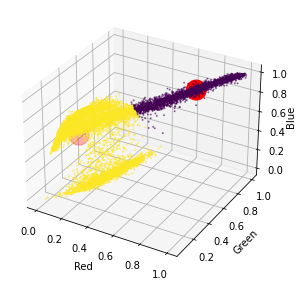

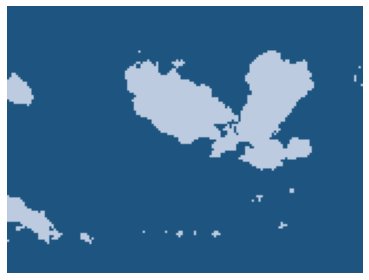

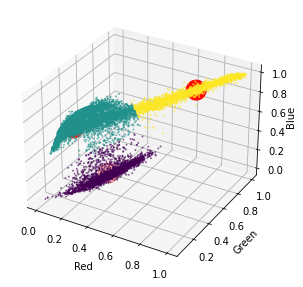

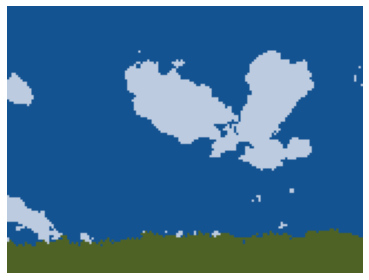

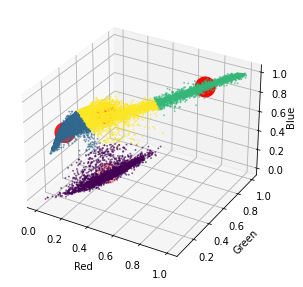

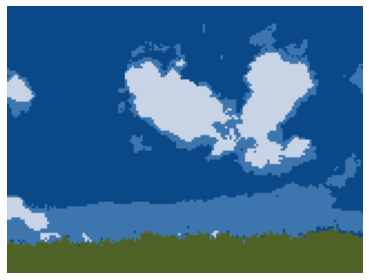

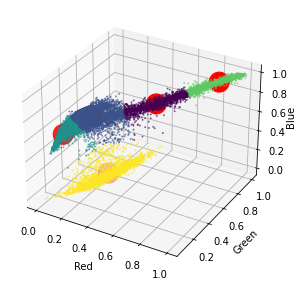

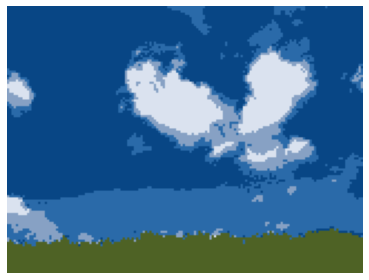

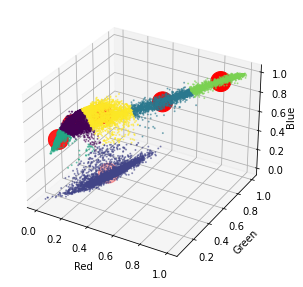

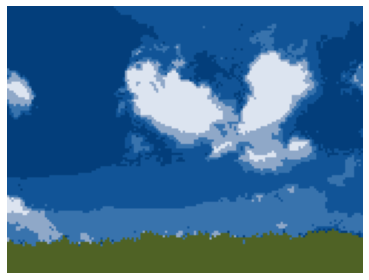

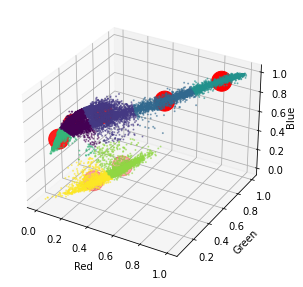

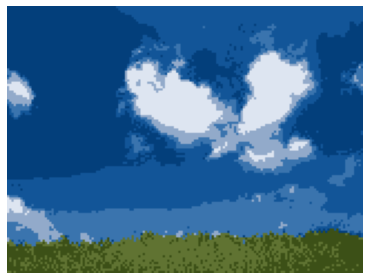

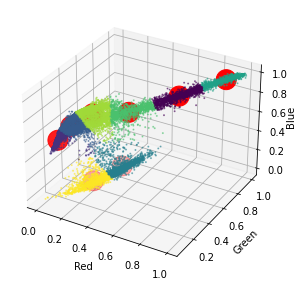

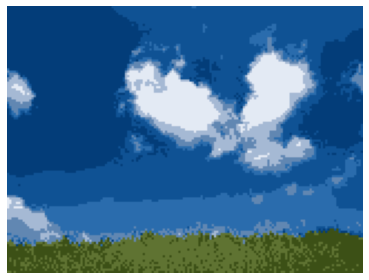

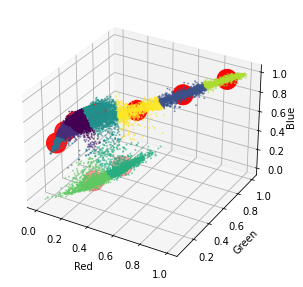

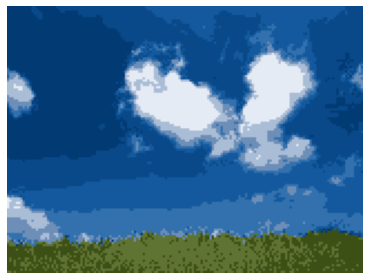

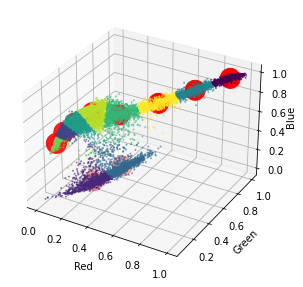

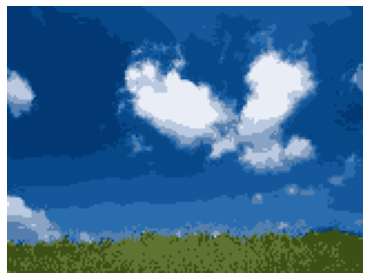

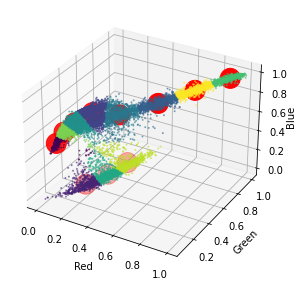

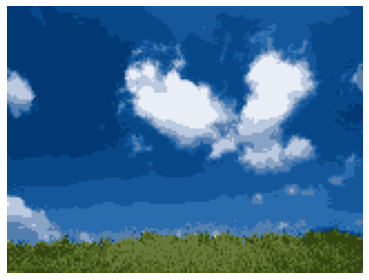

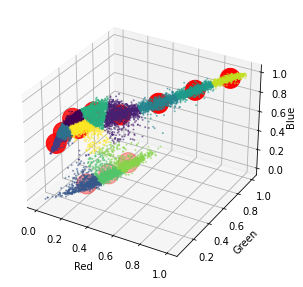

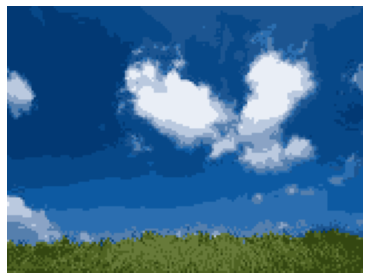

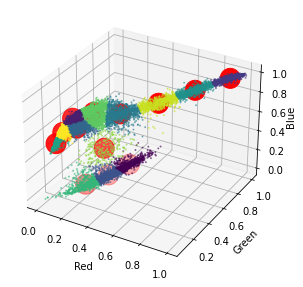

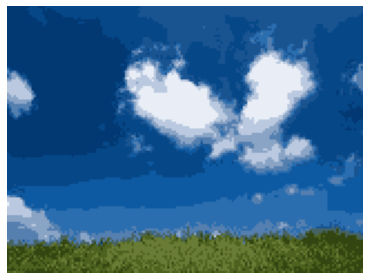

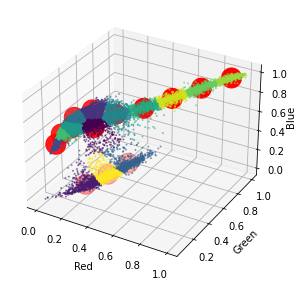

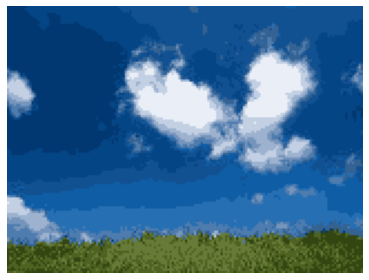

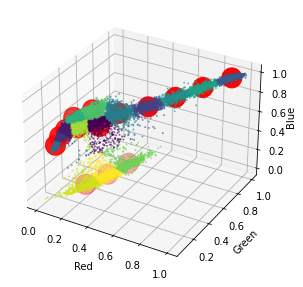

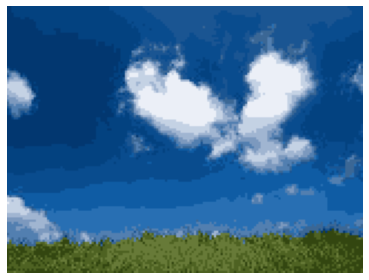

In [128]:
# Reshape the data to a matrix of total_num_pixels x 3
num_pixel_land = im_landscape.shape[0] * im_landscape.shape[1]      # total mumber of pixels
im_landscape_r = im_landscape.reshape(num_pixel_land, 3)            # reshaped landscape image
im_landscape_norm = im_landscape_r/255.                             # normalized landscape image

# Print the shape of the data and the min and max values of the pixels
print('the reshaped landscape array has shape:', im_landscape_norm.shape, '\nthe minimum value of the pixels is', im_landscape_norm.min(), 'and the maximum is:', im_landscape_norm.max())

# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')
inertia = list()
for k in range(2,16):
    # Define the K-means model
    model = KMeans(n_clusters = k, n_init = 'auto', init = 'random', max_iter = 50)

    # Fit the model to the data
    model.fit(im_landscape_norm)
    sk_clusters = model.labels_

    # Get the cluster centers
    sk_centroids = model.cluster_centers_

    # Extarct the color values of the centers
    sk_new_landscape = np.array([sk_centroids[i] for i in sk_clusters])

    # Reshape the data to the original image shape
    sk_landscape_re = sk_new_landscape.reshape((im_landscape.shape[0], im_landscape.shape[1], 3)) 

    # Update the inertia
    inertia.append(model.inertia_)
    
    # Plot the scatter plot and the ricolored imag
    scatter_plot(im_landscape_norm, sk_clusters, sk_centroids)

    # Plot the recolored image
    img_plot(sk_landscape_re)


#### Using the reindeer image

the reshaped landscape array has shape: (140500, 3) 
the minimum value of the pixels is 0.0 and the maximum is: 1.0

K-means clustering with different values of K (2-15):


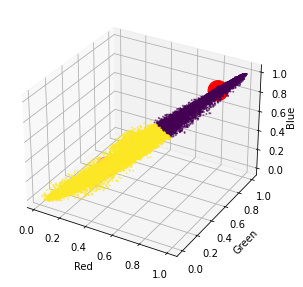

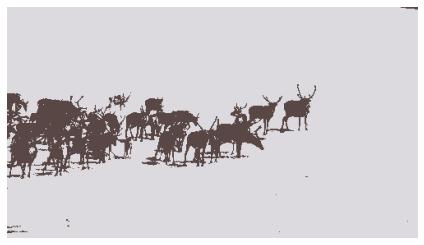

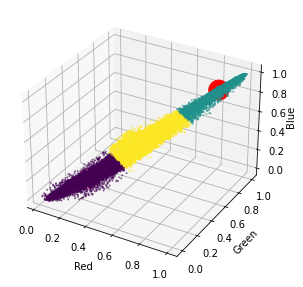

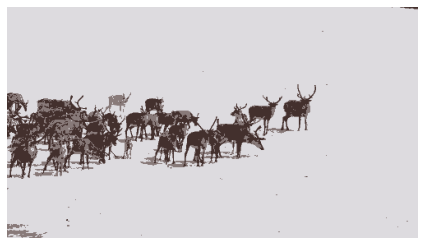

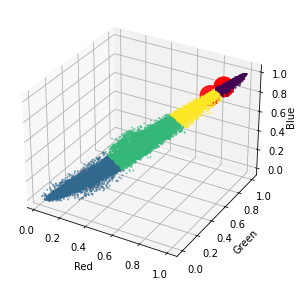

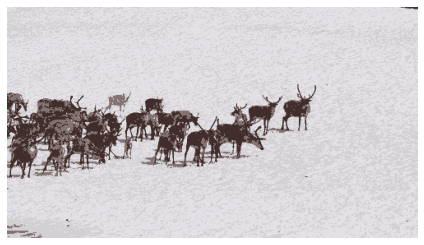

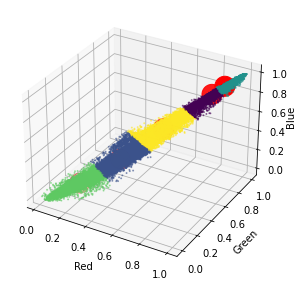

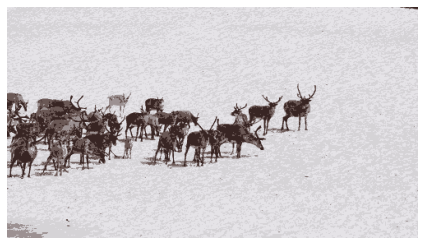

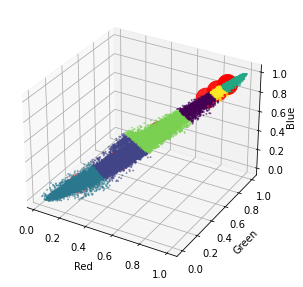

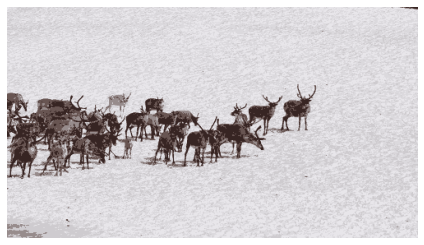

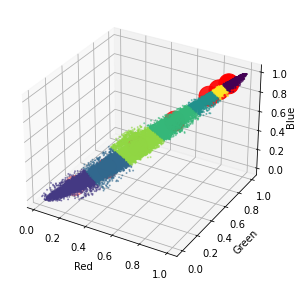

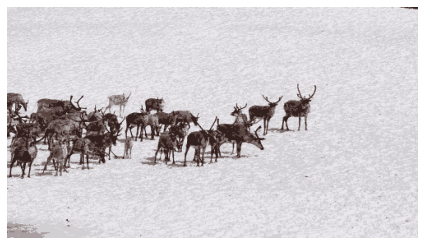

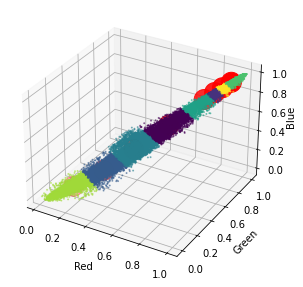

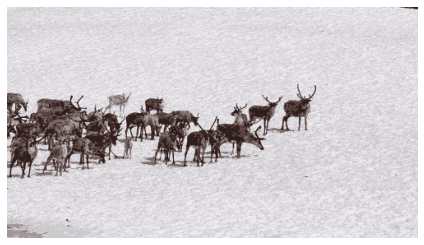

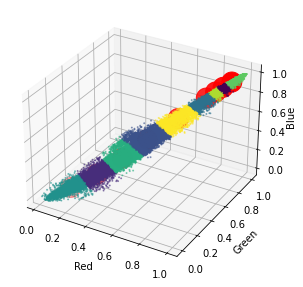

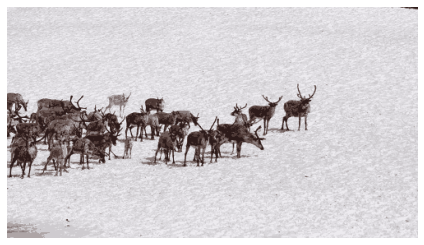

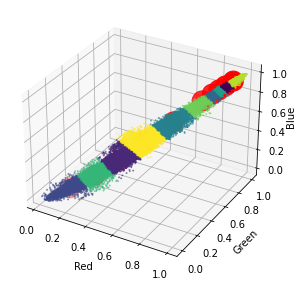

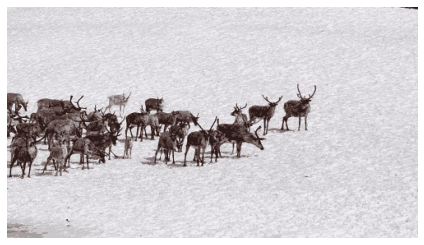

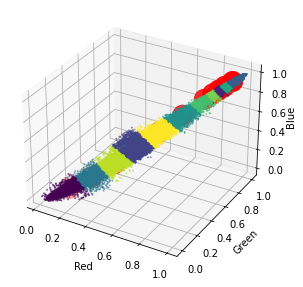

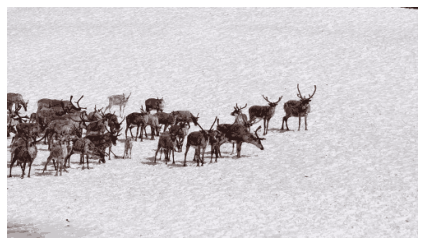

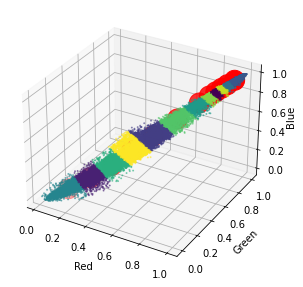

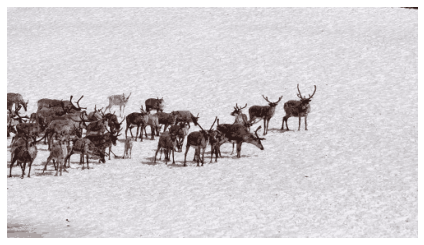

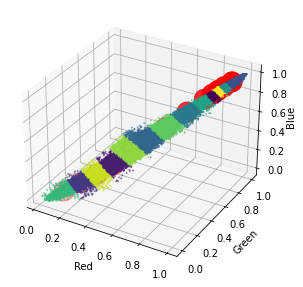

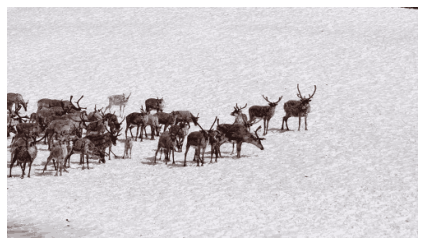

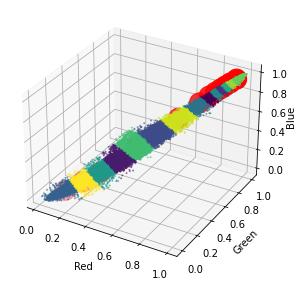

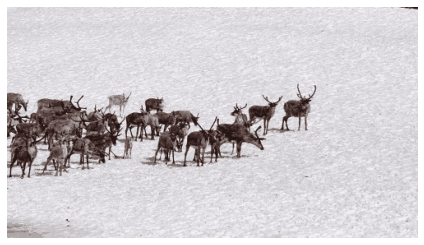

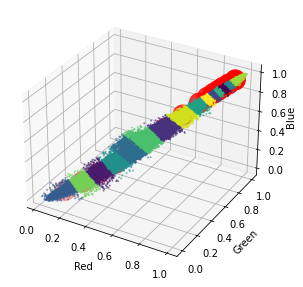

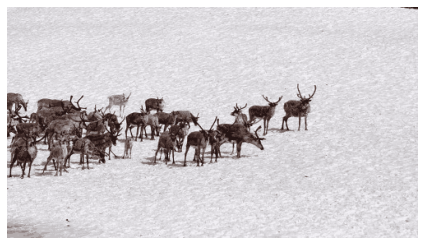

In [129]:
# Reshape the data to a matrix of total_num_pixels x 3
num_pixel_reindeer = im_reindeer.shape[0] * im_reindeer.shape[1]
im_reindeer_r = im_reindeer.reshape(num_pixel_reindeer, 3)
im_reindeer_norm = im_reindeer_r/255.

# Print the shape of the data and the min and max values of the pixels
print('the reshaped landscape array has shape:', im_reindeer_norm.shape, '\nthe minimum value of the pixels is', im_reindeer_norm.min(), 'and the maximum is:', im_reindeer_norm.max())

# Cycle over different values of K and plot the results for each value
print('\nK-means clustering with different values of K (2-15):')

inertia = list()
for k in range(2,16):
    # Define the K-means model
    model = KMeans(n_clusters = k, n_init = 'auto', max_iter = 50)

    # Fit the model to the data
    model.fit(im_reindeer_norm)
    sk_clusters = model.labels_

    # Get the cluster centers
    sk_centroids = model.cluster_centers_

    # Extarct the color values of the centers
    sk_new_reindeer = np.array([sk_centroids[i] for i in sk_clusters])

    # Reshape the data to the original image shape
    sk_reindeer_re = sk_new_reindeer.reshape((im_reindeer.shape[0], im_reindeer.shape[1], 3)) 

    # Update the inertia
    inertia.append(model.inertia_)
    
    # Plot the scatter plot and the ricolored imag
    scatter_plot(im_reindeer_norm, sk_clusters, sk_centroids)

    # Plot the recolored image
    img_plot(sk_reindeer_re)


### TO DO (A.7)

Plot for different values of k (e.g. k between 2 and 15) the respective error of the kmeans algorithm 

In [130]:
def inertia_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Inertia over different k (reindeer image)')
    plt.ylabel('Inertia')
    plt.xlabel('# of clusters k')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

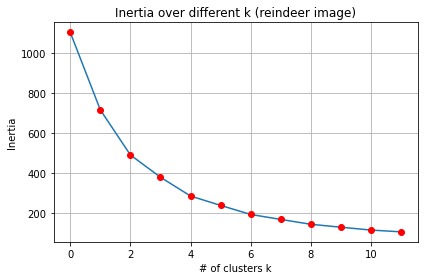

In [131]:
inertia_plot(inertia) 

### TO DO (AQ.3) [Answare the following]

Compare the results with different values of k, what do you observe? 

Analyze also the error, which one do you think is the optimal value of k?

Is there a single, clear answer?

**ANSWER A.Q3:** As the number of clusters increases, the image becomes closer to the original.

Looking at the error plot, we can observe that the value of the error decreases exponentially-like with the number of clusters. With tha values we used, the best number of clusters is 16, as the error is lower.

Since the error value tends to stabilize as the number of clusters increases, it becomes more difficult to decide the best value of k: the differences in the images will be more and more slight.

---

## B) Linkage-based clustering

The second part of the assignment concern instead linkage-based clustering. We will use the AgglomerativeClustering module of sklearn. 

### TO DO (B.0)

Load the sample dataset located at `data/moon_data.npz`

In [132]:
# Load sample data
data = np.load('data/moon_data.npz')

# Extract data
x = data['X']
labels_true = data['labels_true']

### TO DO (B.1)

Now exploit the AgglomerativeClustering algorithm from the sklearn library on the provided sample data points. Use the "single" linkage type that correspond to the minimum distance criteria seen in the lectures and 2 clusters. Notice that the "single" option has been introduced recently in sklearn, if you get an error ensure you have a recent version of the library. Plot the resulting clustering.

In [133]:
# Compute Agglomerative Clustering
# Define the Agglomerative Clustering model
model = AgglomerativeClustering(linkage = 'single')

# Fit the model to the data
model.fit(x)

# Compute the number of clusters in labels, ignoring noise if present.
clusters = model.labels_        # labels of the cluster for every point

# Print the results
print(clusters)

[1 0 1 ... 1 0 1]


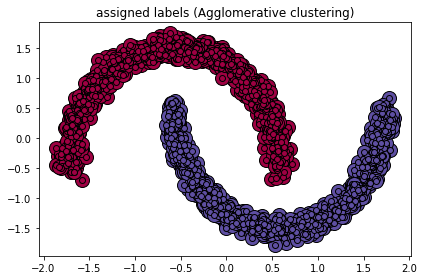

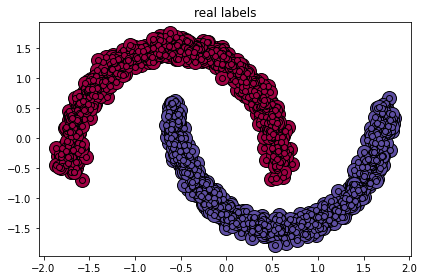

In [134]:
# Plot result 
# Sugestion: use the function cluster_plot()
cluster_plot(clusters, x, 'assigned labels (Agglomerative clustering)')
cluster_plot(labels_true, x, 'real labels')

### TO DO (B.2)

Now try the KMeans with two clusters on the same dataset we used for the AgglomerativeClustering algorithm.

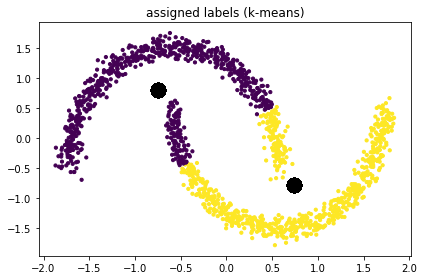

In [135]:
# Define the K-means model
model = KMeans(2, n_init = 'auto', init = 'random', max_iter = 50)

# Fit the model to the data
model.fit(x)

# Get the cluster centers
clusters = model.labels_        # labels of the cluster for every point

# Extarct the color values of the centers
centroids = model.cluster_centers_                      # position (color value) of the center of the centroids
center_x = np.array([centroids[i] for i in clusters])   # assign every point to the position (color value) of its cluster

# Plot the results
# Sugestion: use the function scatter_plot_2d()
scatter_plot_2d(x, clusters, center_x, 'assigned labels (k-means)')

### TO DO (B.Q1) [Answare the following]

Compare the results of K-means and Agglomerative Clustering and explain what you observe and why?

**ANSWER B.Q1:** As we can observe, the results found with the agglomerative clustering algorithm and the k-means algorithm are different: the first one, in particular, assigns the right labels to the point with respect to the labels of the dataset, since the clusters are created in a way such that closest point belong to the same cluster.\
The k-means algorithm, instead, assignes different lables with respect to the labels of the dataset, since the point are linked to the cluster which center is closest.

---